In [1]:
# #based on aeronetlab/dev:stable docker image

# # Update aeronetlib
# !pip install -U aeronet==0.0.3 --user

# # Update segmentation_models library
# !pip install -U segmentation_models==0.2.0 --user

### Load data

In [1]:
import os

In [14]:
DATA_DIR = '../datasets/buildings_segmentation'
DATA_URL = 'https://github.com/aeronetlab/aeronet-tutorials/releases/download/0.0.1/buildings_segmentation.zip'


command_1 = 'wget -P ../datasets/ {url}'.format(url=DATA_URL)
command_2 = 'unzip {} -d {}'.format(DATA_DIR, DATA_DIR)
command_3 = 'rm {}.zip'.format(DATA_DIR)

if not os.path.exists(DATA_DIR):
    os.system(command_1)
    os.system(command_2)
    os.system(command_3)

### Read data

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from aeronet.dataset import BandCollection, parse_directory
from sklearn.model_selection import train_test_split

In [3]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

CHANNLES = ['RED', 'GRN', 'BLU']
LABELS = ['100']

SAMPLE_SIZE = (256, 256)

In [4]:
# read data
x_raw = BandCollection(parse_directory(TRAIN_DIR, CHANNLES))
print("X projection:", x_raw.crs)
print("X resolution:", x_raw.res)

y_raw = BandCollection(parse_directory(TRAIN_DIR, LABELS))
print("Y projection:", y_raw.crs)
print("Y resolution:", y_raw.res)

X projection: +init=epsg:3857
X resolution: (0.5971642834774684, 0.5971642834774684)
Y projection: +init=epsg:3857
Y resolution: (0.5971642834774684, 0.5971642834774684)


In [5]:
def generate_samples(band_collection, sample_size=(512, 512)):
    """Generate small samples (tiles) from give band collection
    
    Args:
        band_collection: aeronet.BandCollection
        sample_size: tuple of two int (height, width), size in pixels
    
    Return:
        samples: np.array of shape (N_SAMPLES, HEIGHT, WIDTH, CHANNELS)
    """
    
    samples = []
    for sample in band_collection.generate_samples(*sample_size):
        arr = sample.numpy().transpose(1, 2, 0)
        samples.append(arr)
    return np.stack(samples)

# slice data to small pieces to train
x = generate_samples(x_raw.ordered(*CHANNLES), SAMPLE_SIZE)
y = generate_samples(y_raw, SAMPLE_SIZE)

print("Generated {} samples.".format(len(x)))

Generated 324 samples.


In [6]:
# split data to train and validation subsets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print('Train samples - {}'.format(x_train.shape[0]))
print('Validation samples - {}'.format(x_val.shape[0]))

Train samples - 259
Validation samples - 65


## Visualise data


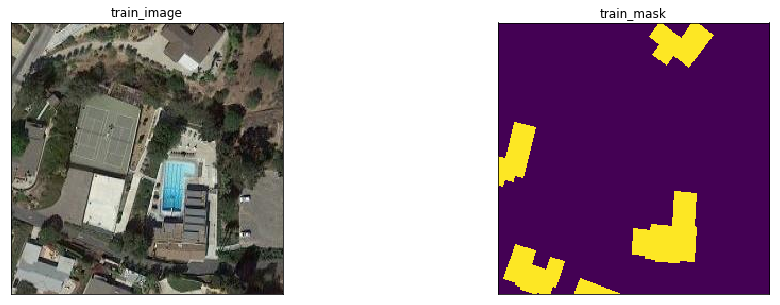

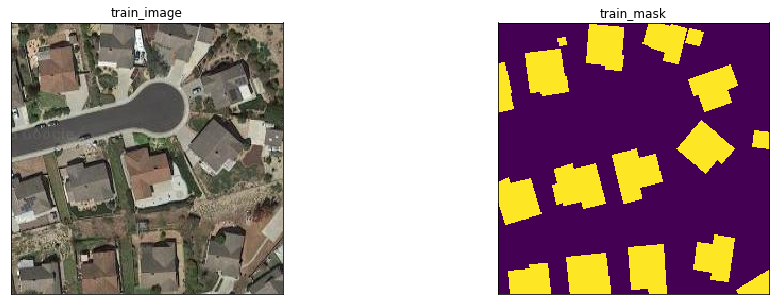

In [7]:
import matplotlib.pyplot as plt

def show_images(figsize=(16, 5), **images):
    """PLot images in row"""
    n = len(images)
    plt.figure(figsize=figsize)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name)
        plt.imshow(image)
    plt.show()
    
n = 150
show_images(
    train_image=x_train[n],
    train_mask=y_train[n].squeeze(),
)

n = 156
show_images(
    train_image=x_train[n],
    train_mask=y_train[n].squeeze(),
)

## Data augmentation

In [8]:
def make_aug_data(arr):
    aug_arr = np.concatenate(
        [
            arr,
            arr[:, ::-1],                       # horizontal flip
            arr[:, :, ::-1],                    # vertical flip
            arr[:, ::-1, ::-1],                 # horizontal + vertical flip
            np.rot90(arr, k=1, axes=(1, 2)),    # rotated 90 degrees
            np.rot90(arr, k=2, axes=(1, 2)),    # rotated 180 degrees
            np.rot90(arr, k=3, axes=(1, 2)),    # rotated 270 degrees
        ]
    )
    return aug_arr

x_train = make_aug_data(x_train)
y_train = make_aug_data(y_train)

## Train model

In [9]:
from keras.optimizers import Adam

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import get_jaccard_score

Using TensorFlow backend.
/opt/anaconda/anaconda3/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [10]:
BACKBONE = 'resnet18'
preprocess_input = get_preprocessing(BACKBONE)

In [11]:
model = Unet(
    backbone_name=BACKBONE, 
    encoder_freeze=False, # reduce number of training parameters
    decoder_filters=(128, 64, 32, 16, 8), # reduce number of training parameters, prevent overfitting
)

In [12]:
# define optimizer, loss function and metric
model.compile(
    optimizer=Adam(lr=0.0002), 
    loss=bce_jaccard_loss, 
    metrics=[get_jaccard_score(per_image=False)],
)

In [13]:
# prepare data
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [14]:
# train model
model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20,
    validation_data=(x_val, y_val), 
    shuffle=True,
    verbose=2,
)

Train on 1813 samples, validate on 65 samples
Epoch 1/20
 - 16s - loss: 1.6503 - score: 0.1042 - val_loss: 1.5499 - val_score: 0.1422
Epoch 2/20
 - 11s - loss: 1.3962 - score: 0.1322 - val_loss: 1.4159 - val_score: 0.1659
Epoch 3/20
 - 11s - loss: 1.2590 - score: 0.1624 - val_loss: 1.2668 - val_score: 0.1805
Epoch 4/20
 - 11s - loss: 1.1524 - score: 0.1963 - val_loss: 1.1256 - val_score: 0.2185
Epoch 5/20
 - 11s - loss: 1.0613 - score: 0.2369 - val_loss: 1.0850 - val_score: 0.2471
Epoch 6/20
 - 11s - loss: 0.9833 - score: 0.2820 - val_loss: 1.0105 - val_score: 0.2797
Epoch 7/20
 - 11s - loss: 0.9231 - score: 0.3220 - val_loss: 0.9771 - val_score: 0.3029
Epoch 8/20
 - 11s - loss: 0.8706 - score: 0.3672 - val_loss: 0.9533 - val_score: 0.3181
Epoch 9/20
 - 11s - loss: 0.8279 - score: 0.4066 - val_loss: 0.9402 - val_score: 0.3292
Epoch 10/20
 - 11s - loss: 0.7891 - score: 0.4472 - val_loss: 0.9139 - val_score: 0.3543
Epoch 11/20
 - 11s - loss: 0.7569 - score: 0.4860 - val_loss: 0.8849 - va

## Visualize results

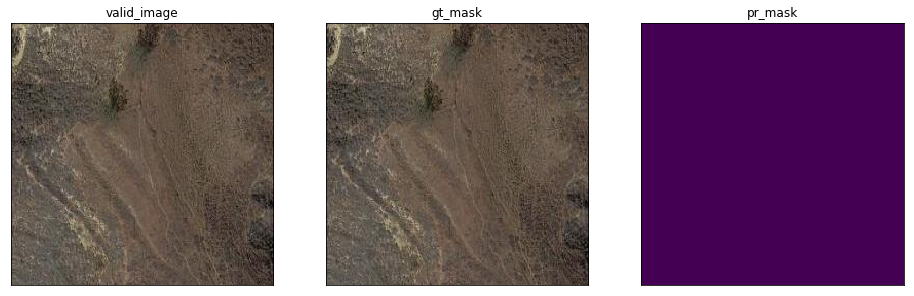

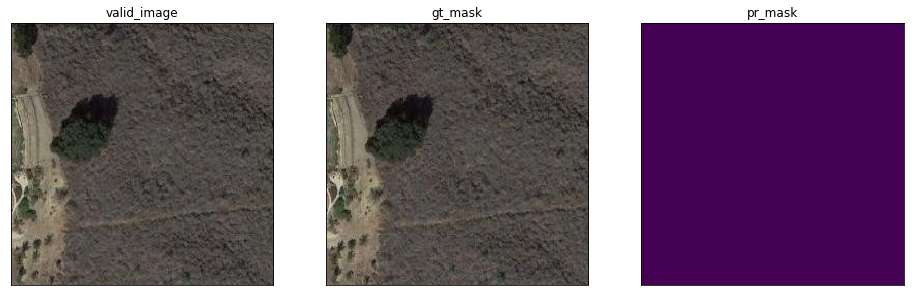

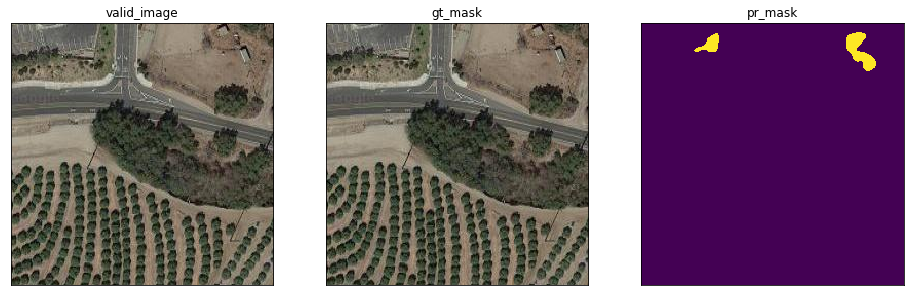

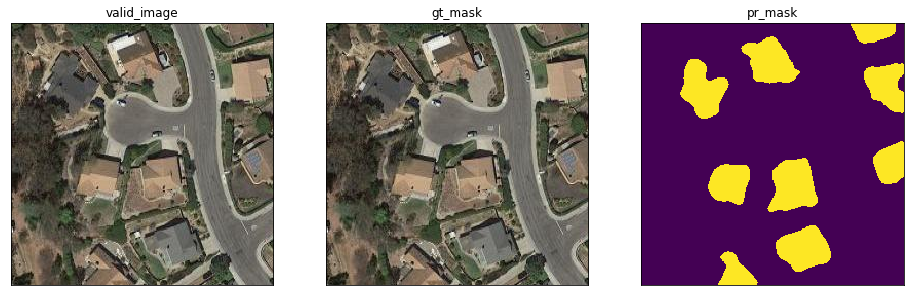

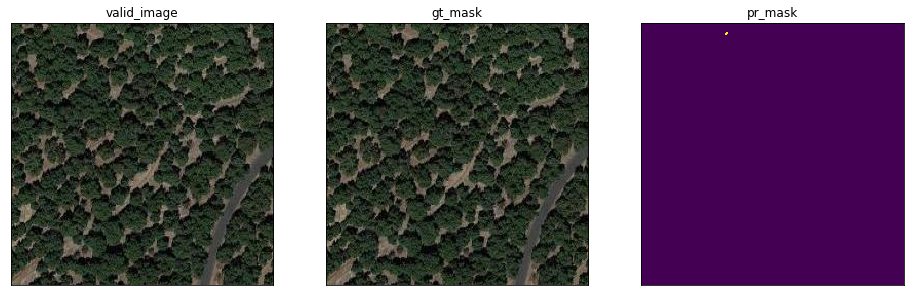

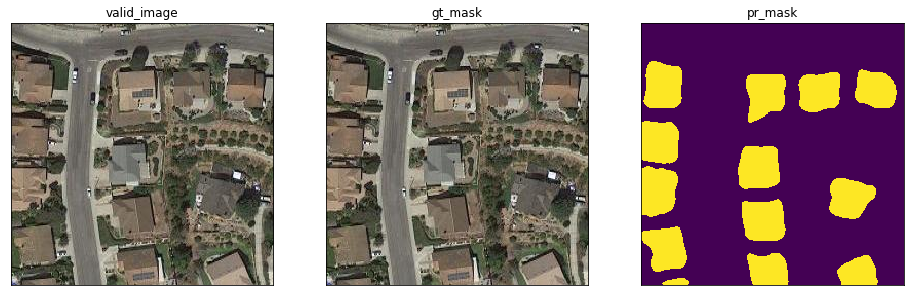

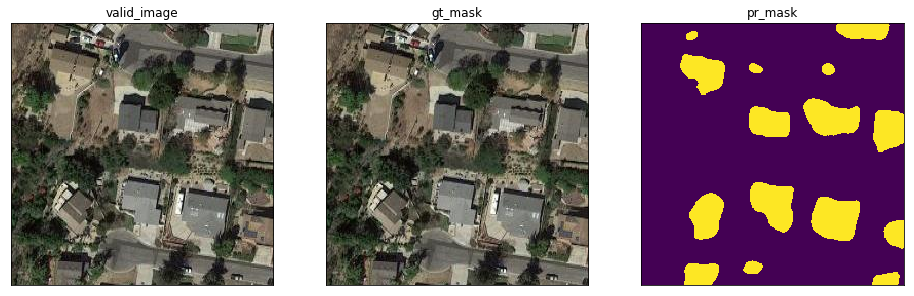

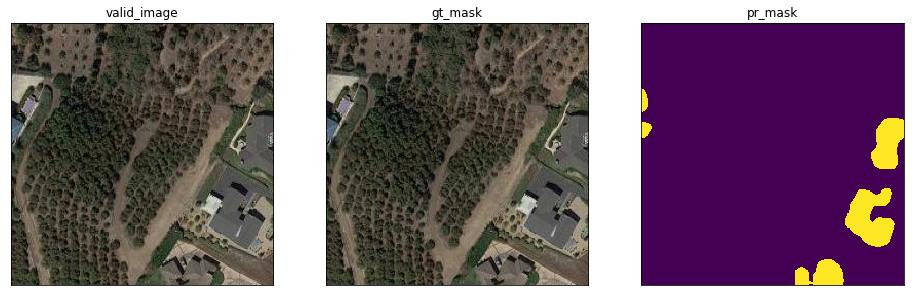

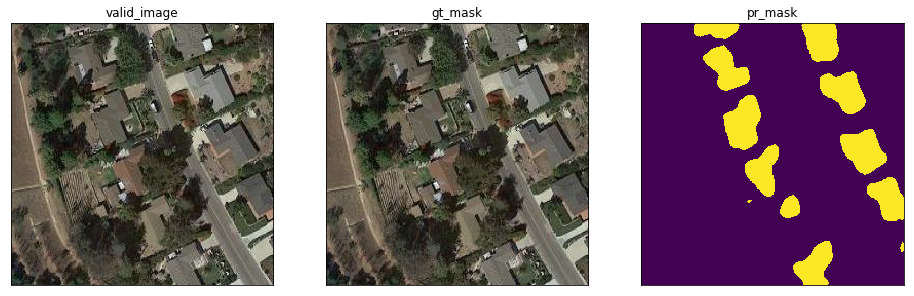

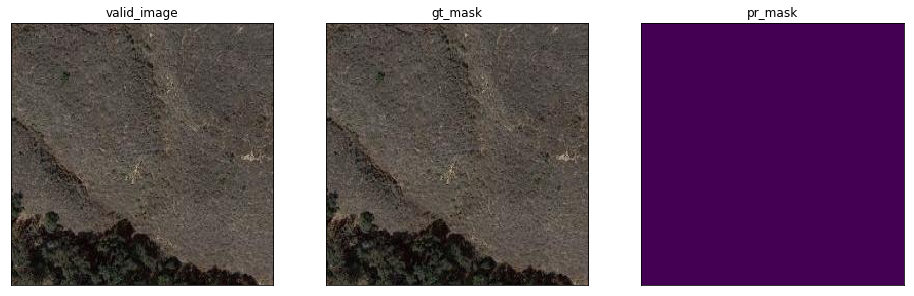

In [15]:
for n in range(30, 40):
    
    image = x_val[n]
    gt_mask = x_val[n].squeeze()
    pr_mask = model.predict(np.expand_dims(image, 0)).round().squeeze()

    show_images(
        valid_image=image,
        gt_mask=gt_mask,
        pr_mask=pr_mask,
    )

## Inference

In [16]:
from aeronet.dataset import Predictor

In [17]:
# read test data
x_test = BandCollection(parse_directory(TEST_DIR, CHANNLES))
y_test = BandCollection(parse_directory(TEST_DIR, LABELS))

In [18]:
class InferenceModel:
    """
    Inference model, model which include all preprocessing steps
    should be passed to Predictor as processing_fn
    """
    def __init__(self, model, preprocessing_fn):
        self.model = model
        self.preprocessing_fn = preprocessing_fn
        
    def __call__(self, sample):
        
        # transform sample (geospation object with crs, transform, etc..) to array
        x = sample.numpy().transpose(1, 2, 0)
        x = np.expand_dims(x, 0)
        
        # preprocess sample
        x = self.preprocessing_fn(x)
        
        # predict
        y = self.model.predict(x).squeeze(0)
        y = y.round().astype('uint8')
        
        # transpose to raster format (CNAHHELS, H, W)
        y = y.transpose(2, 0, 1)
        
        return y

# create infernce model and predictor object
inference_model = InferenceModel(model, preprocess_input)

# `predictor` object process `band collection` with `inference model` 
# usind sliding window approach 
# (nesessery for big raster files which are not fit to RAM)
predictor = Predictor(
    input_channels=CHANNLES,
    output_labels=LABELS,
    processing_fn=inference_model, 
)

In [19]:
# run band collection processing
pred = predictor.process(bc=x_test, output_directory='./prediction/2/')

100%|██████████| 9/9 [00:02<00:00,  3.14it/s]


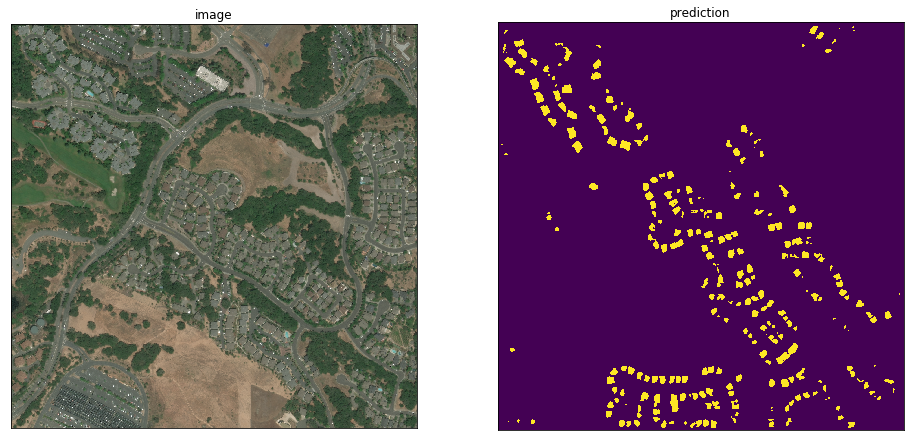

In [20]:
# visualize results

image = (x_test.ordered(*CHANNLES)
               .numpy()
               .transpose(2,1,0))
prediction = pred.numpy().squeeze()

show_images(
    image=image,
    prediction=prediction,
    figsize=(16,8)
)